In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from lmfit.models import GaussianModel, SkewedGaussianModel
from lmfit import Parameters
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools
from source.util import scatter_tools

In [2]:
def get_al_idc_length(f0: float or np.ndarray) -> float or np.ndarray:
    """Function to return the variable idc length to build aluminium inductor ortho-IDC Lekids for mask

    :param f0: F0 in Hz of LEKID.
    """
    return -2.558e-25 * f0**3 + 2.237e-15 * f0**2 - 7.461e-06 * f0 + 9096


def get_nb_f0(idc_length: float or np.ndarray) -> float or np.ndarray:
    """Function to return the f0 value of a niobium inductor ortho-IDC Lekid give the variable idc length.

    :param idc_length: variable IDC length in um.
    """
    return (
        -0.07501 * idc_length**3
        + 462.4 * idc_length**2
        - 1.451e6 * idc_length
        + 3.236e9
    )

In [3]:
data_directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\ripple_v3_ANLw001\slim_ebeam_test\slim_ebeam_test"

device_data_filename = "freq_scheduling_B_C.pk"
device_file_path = os.path.join(data_directory, device_data_filename)

devices_data_dict = np.load(device_file_path, allow_pickle=True)
device_b_f0_array = np.array(devices_data_dict["B"]) * 1e9
device_c_f0_array = np.array(devices_data_dict["C"]) * 1e9

In [4]:
al_target_data_filename = "target_detector_f0_array.txt"
al_target_data_file_path = os.path.join(data_directory, al_target_data_filename)

al_target_f0_array = np.loadtxt(al_target_data_file_path)
al_idc_lengths = get_al_idc_length(al_target_f0_array)

nb_target_f0_array = get_nb_f0(al_idc_lengths)

In [5]:
print(len(device_b_f0_array)/160)
print(len(device_c_f0_array)/160)

0.925
0.9875


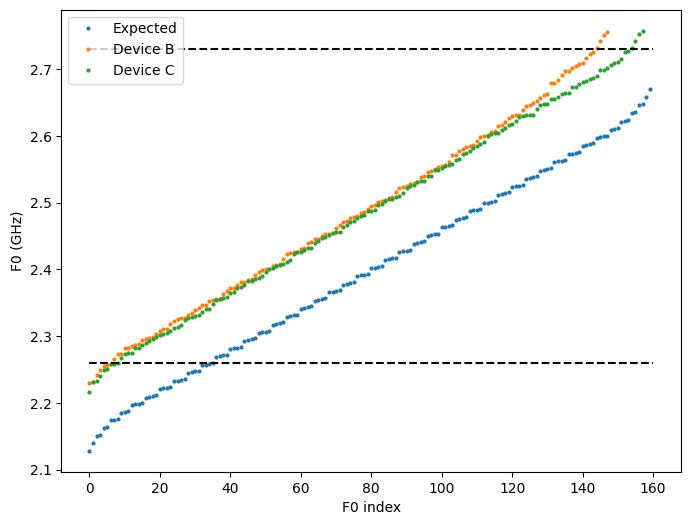

In [6]:
max_frequency = 2.73e9
min_frequency = 2.26e9

plt.figure(figsize=(8, 6))
plt.plot(nb_target_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Expected")
plt.plot(device_b_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Device B")
plt.plot(device_c_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Device C")
plt.hlines(y=[min_frequency*1e-9, max_frequency*1e-9], xmin=0, xmax=nb_target_f0_array.size, color="k", linestyles="--")
plt.xlabel("F0 index")
plt.ylabel("F0 (GHz)")
plt.legend()
plt.show()

In [7]:
device_b_mask = np.where((device_b_f0_array > min_frequency) & (device_b_f0_array < max_frequency))[0]
device_c_mask = np.where((device_c_f0_array > min_frequency) & (device_c_f0_array < max_frequency))[0]
print(f"B Tones within range = {device_b_mask.size}")
print(f"C Tones within range = {device_c_mask.size}")

reduced_b_f0_array = device_b_f0_array[device_b_mask]
reduced_c_f0_array = device_c_f0_array[device_c_mask]

B Tones within range = 137
C Tones within range = 145


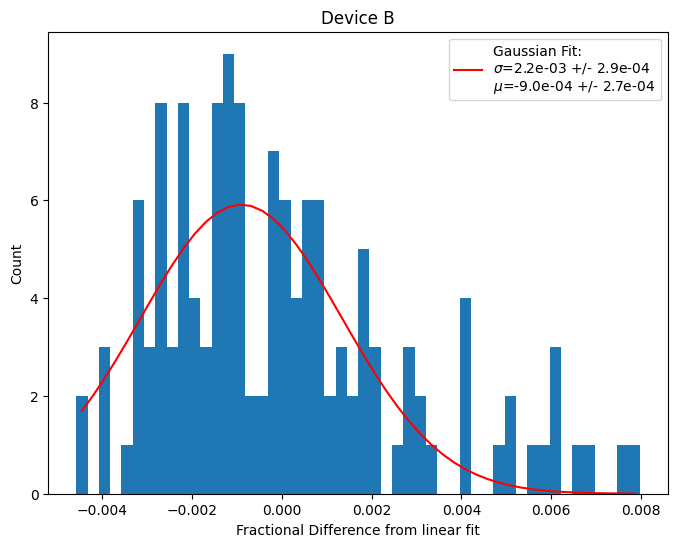

In [8]:
import source.util.general_analysis_tools as general_analysis_tools

n_bins = 50
index_values = np.linspace(0, reduced_b_f0_array.size, reduced_b_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_b_f0_array,
    plot_graph=True,
    plot_title="Device B"
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
b_fractional_difference = (reduced_b_f0_array - best_fit) / best_fit

b_difference_density, b_difference_bins = np.histogram(b_fractional_difference, density=False, bins=n_bins)
b_bin_centres = b_difference_bins[:-1] + (b_difference_bins[1] - b_difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


b_result = model.fit(b_difference_density, parameters, x=b_bin_centres)
result_dict = {}
for name, parameter in b_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(b_fractional_difference, density=False, bins=n_bins)
plt.plot(b_bin_centres, b_result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.title("Device B")
plt.show()


In [9]:
import source.util.general_analysis_tools as general_analysis_tools

tails_removed_mask = np.where(b_fractional_difference < 0.004)[0]

clipped_b_fractional_difference = b_fractional_difference[tails_removed_mask]

clipped_b_difference_density, clipped_b_difference_bins = np.histogram(clipped_b_fractional_difference, density=False, bins=b_difference_bins)
clipped_b_bin_centres = clipped_b_difference_bins[:-1] + (clipped_b_difference_bins[1] - clipped_b_difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


clipped_b_result = model.fit(clipped_b_difference_density, parameters, x=clipped_b_bin_centres)
result_dict = {}
for name, parameter in b_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(clipped_b_fractional_difference, density=False, bins=n_bins)
plt.plot(clipped_b_bin_centres, clipped_b_result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.title("Device B (Tails removed)")
plt.xlim(right=0.0042)
plt.show()


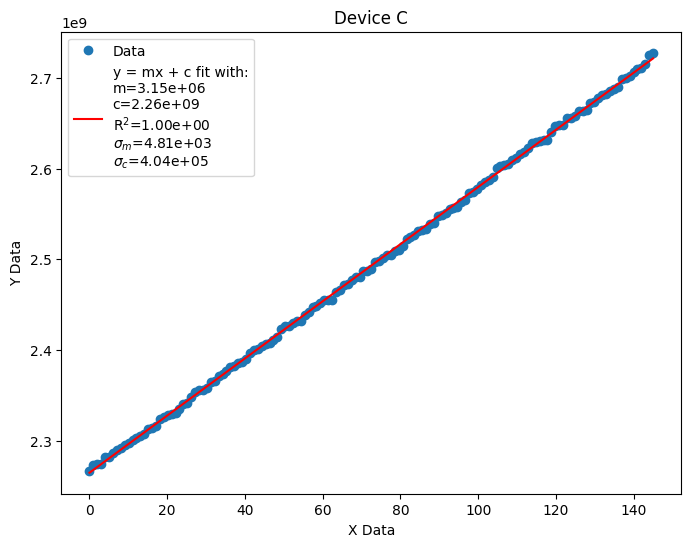

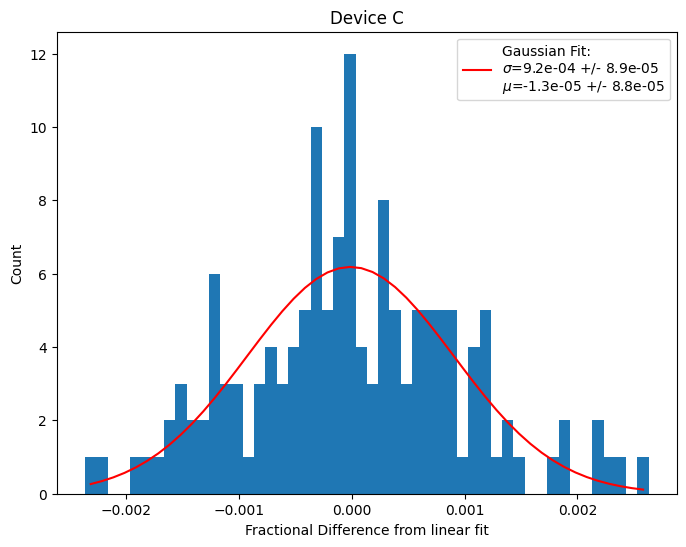

In [10]:
import source.util.general_analysis_tools as general_analysis_tools

index_values = np.linspace(0, reduced_c_f0_array.size, reduced_c_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_c_f0_array,
    plot_graph=True,
    plot_title="Device C"
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
c_fractional_difference = (reduced_c_f0_array - best_fit) / best_fit

c_difference_density, c_difference_bins = np.histogram(c_fractional_difference, density=False, bins=n_bins)
c_bin_centres = c_difference_bins[:-1] + (c_difference_bins[1] - c_difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


c_result = model.fit(c_difference_density, parameters, x=c_bin_centres)
result_dict = {}
for name, parameter in c_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(c_fractional_difference, density=False, bins=n_bins)
plt.plot(c_bin_centres, c_result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.title("Device C")
plt.show()


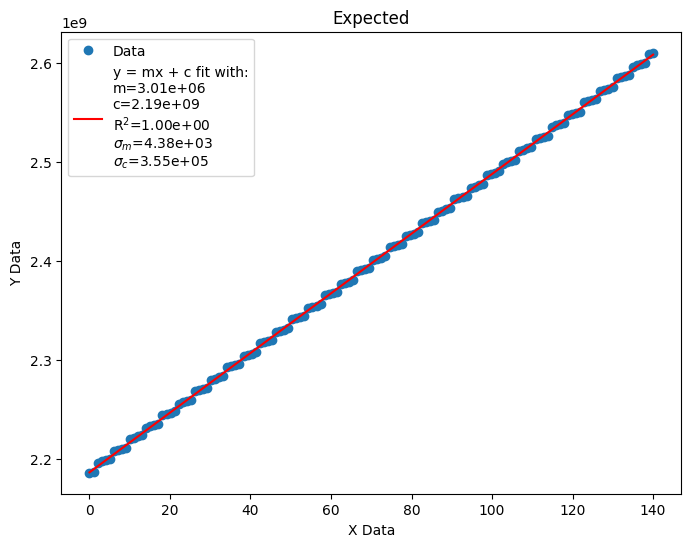

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [18]:
index_values = np.linspace(0, nb_target_f0_array[10:-10].size, nb_target_f0_array[10:-10].size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    nb_target_f0_array[10:-10],
    plot_graph=True,
    plot_title="Expected"
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
expected_fractional_difference = (nb_target_f0_array[10:-10] - best_fit) / best_fit

expected_difference_density, expected_difference_bins = np.histogram(c_fractional_difference, density=False, bins=n_bins)
expected_bin_centres = expected_difference_bins[:-1] + (c_difference_bins[1] - c_difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


expected_result = model.fit(expected_difference_density, parameters, x=expected_bin_centres)
result_dict = {}
for name, parameter in expected_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(expected_fractional_difference, density=False, bins=n_bins)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.title("Expected")
plt.show()

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(b_fractional_difference, density=False, bins=n_bins, label="Device B", alpha=0.3)
plt.hist(c_fractional_difference, density=False, bins=b_difference_bins, label="Device C", alpha=0.3)
plt.hist(expected_fractional_difference, density=False, bins=b_difference_bins, label="Expected", alpha=0.3)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.show(f"Histogram of fractional difference to linear fit in {n_bins} bins")
plt.show()